(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
models_synth_less_conc_90_shapes_feta_192/weights_epoch_1860.h5 detection False
loading second model!
bn: False norm: False 90 True
models_synth_less_conc_90_shapes_feta_192/weights_epoch_1860.h5
Loaded weights from the checkpoint and continued training.
loading second model!
bn: False norm: False 90 True
models_synth_less_conc_90_shapes_feta_192/weights_epoch_0.h5
Loaded weights from the checkpoint and continued training.


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


loading second model!
bn: False norm: False 90 True
models_synth_less_conc_90_shapes_feta_192/weights_epoch_400.h5
Loaded weights from the checkpoint and continued training.


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


loading second model!
bn: False norm: False 90 True
models_synth_less_conc_90_shapes_feta_192/weights_epoch_800.h5
Loaded weights from the checkpoint and continued training.


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


loading second model!
bn: False norm: False 90 True
models_synth_less_conc_90_shapes_feta_192/weights_epoch_1200.h5
Loaded weights from the checkpoint and continued training.


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


loading second model!
bn: False norm: False 90 True
models_synth_less_conc_90_shapes_feta_192/weights_epoch_1600.h5
Loaded weights from the checkpoint and continued training.


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Hard Dice Coefficient: 0.29830620673775704
Soft Dice Coefficient: -0.5331036448478699


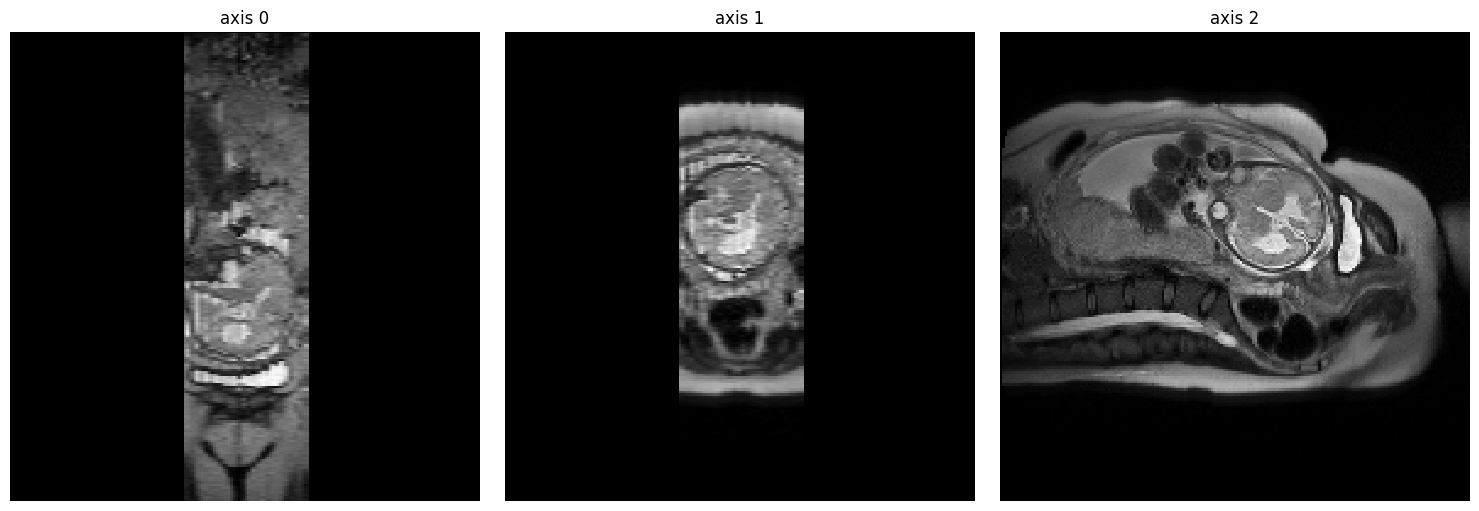

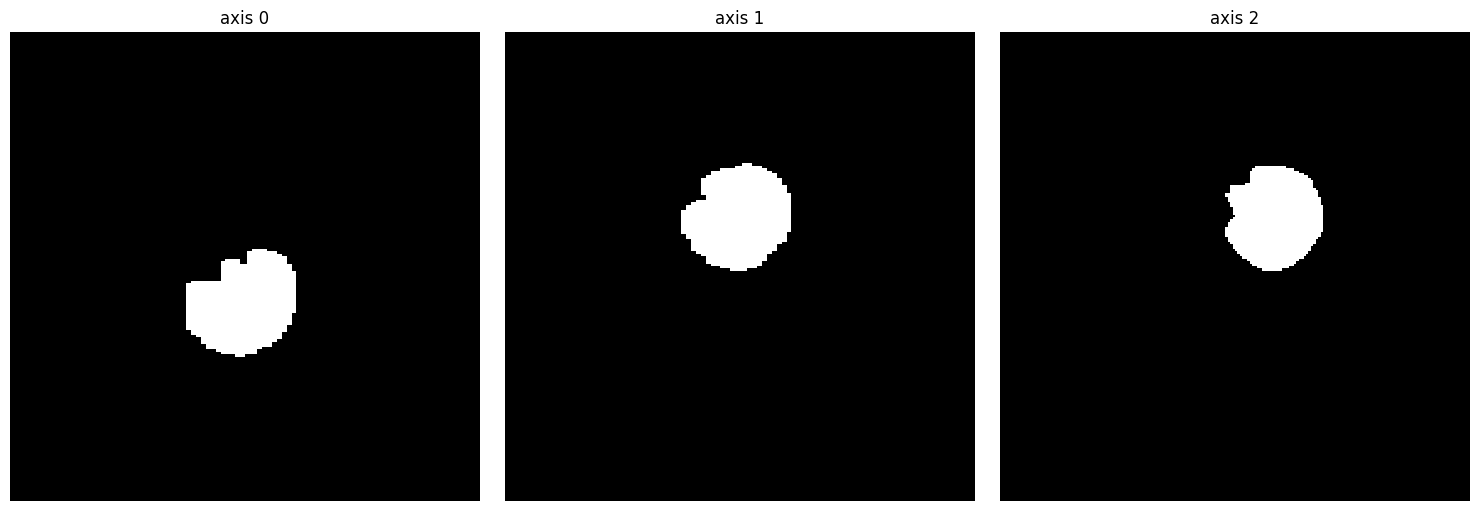

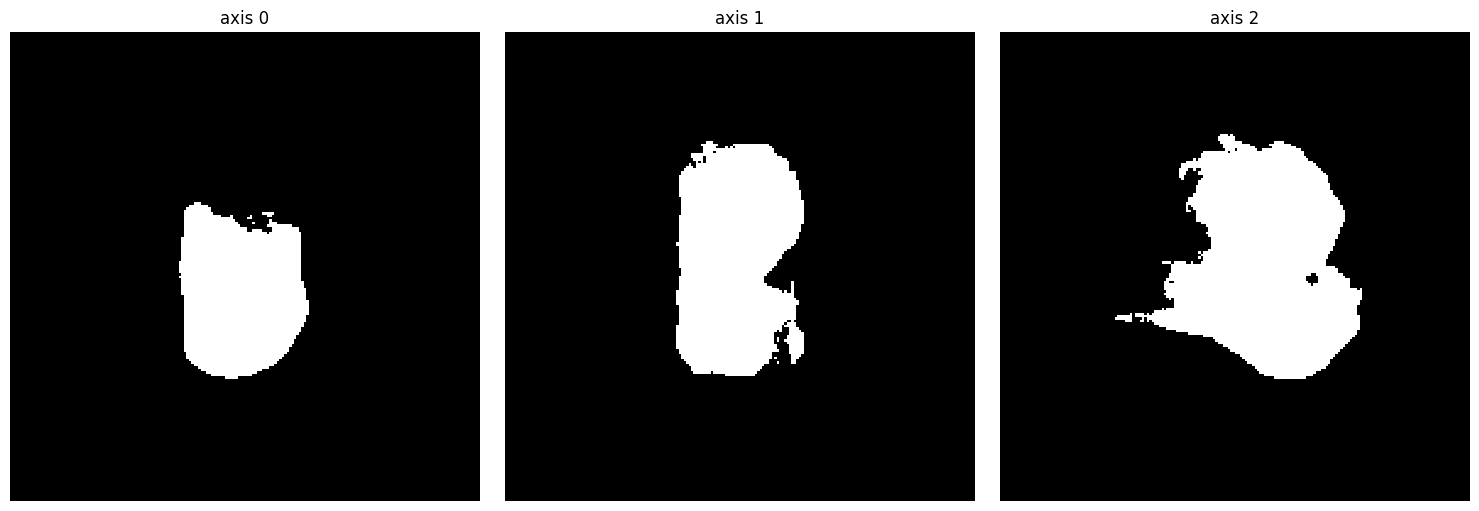

Hard Dice Coefficient: 0.16561326371713841
Soft Dice Coefficient: -0.5107473731040955


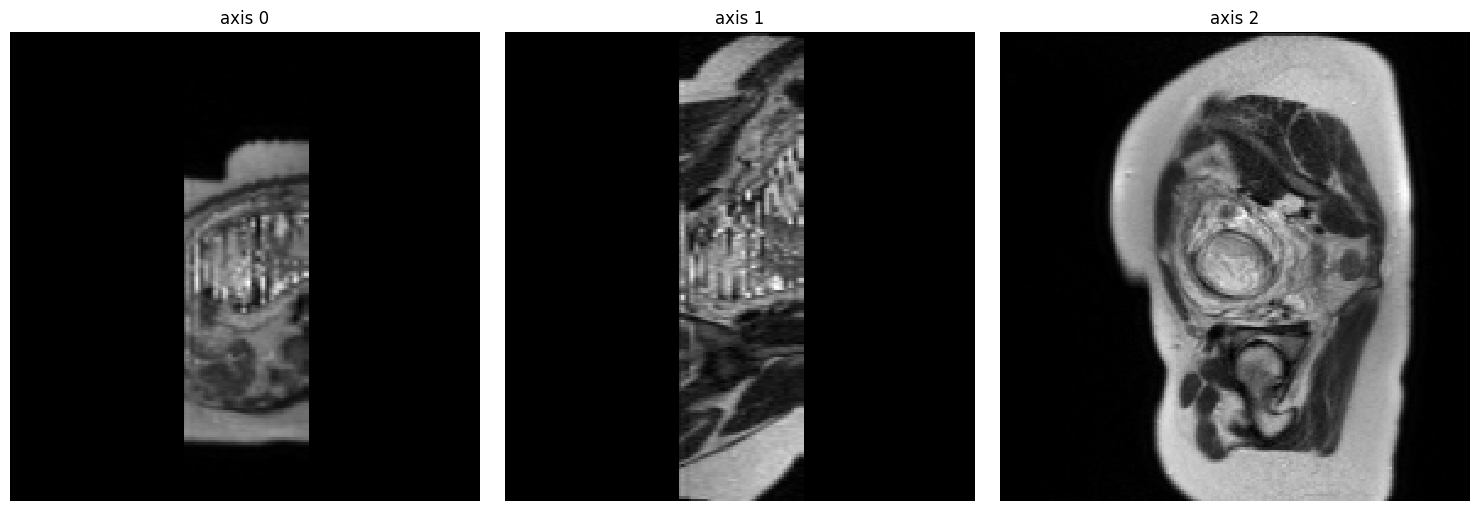

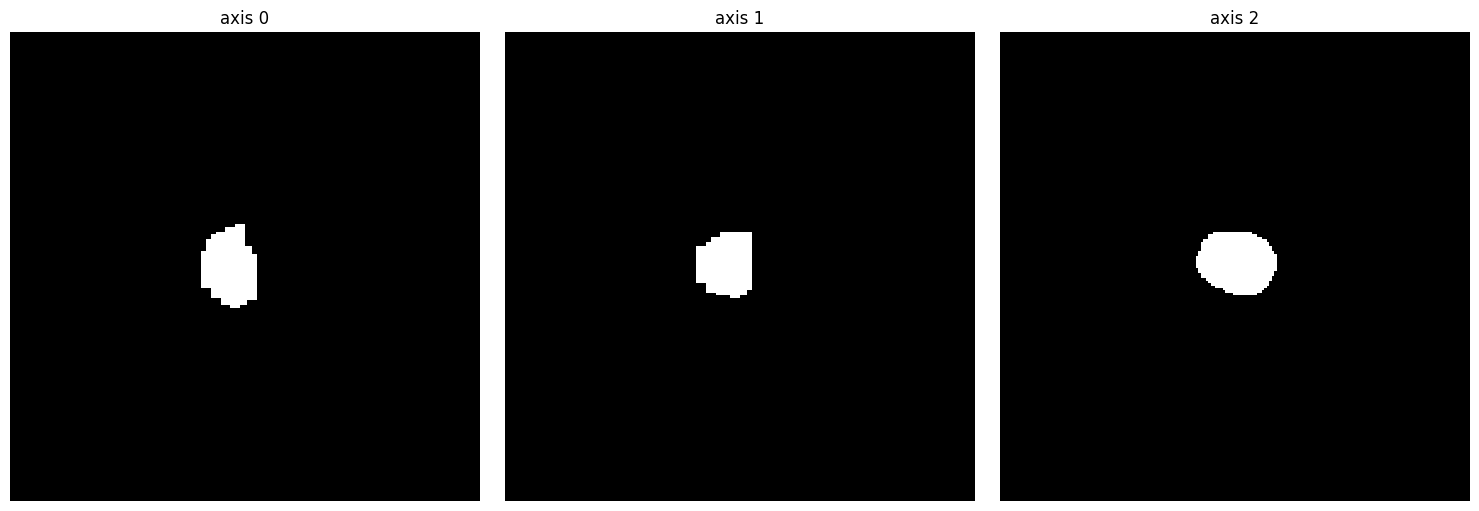

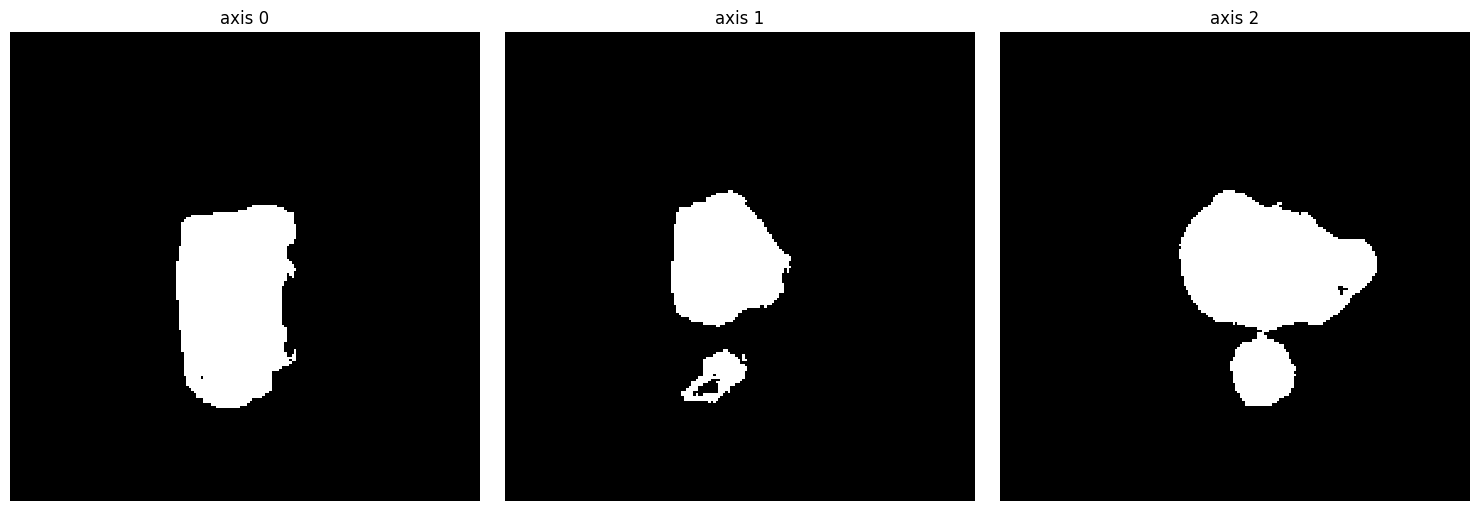

Hard Dice Coefficient: 0.16010906329812935
Soft Dice Coefficient: -0.5102860331535339


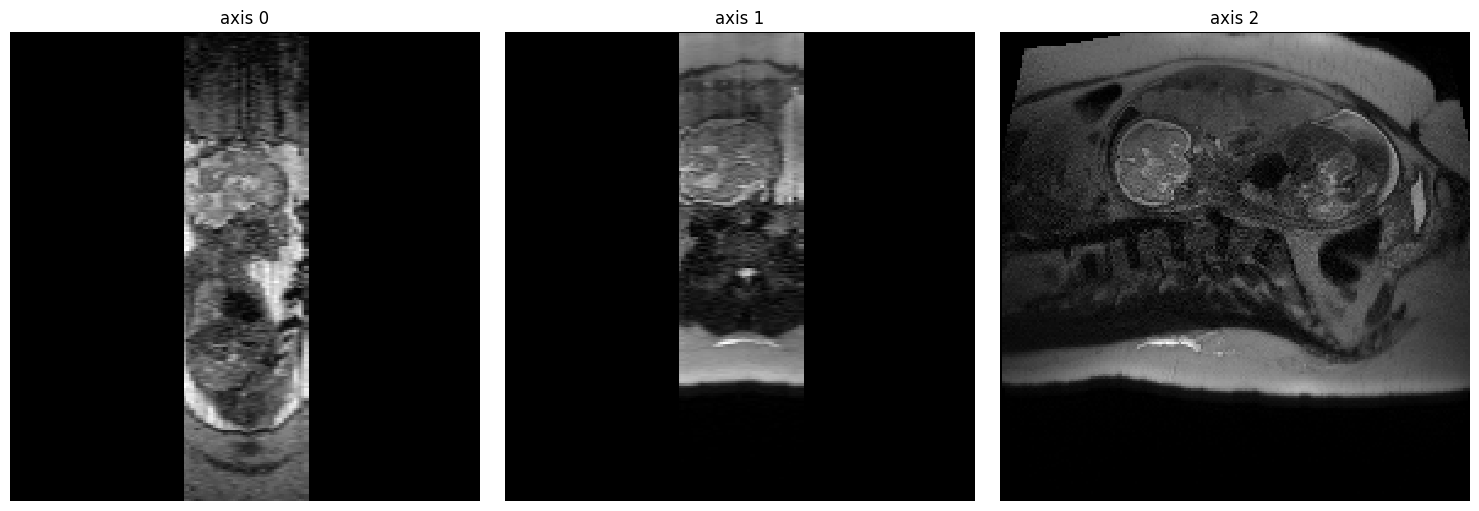

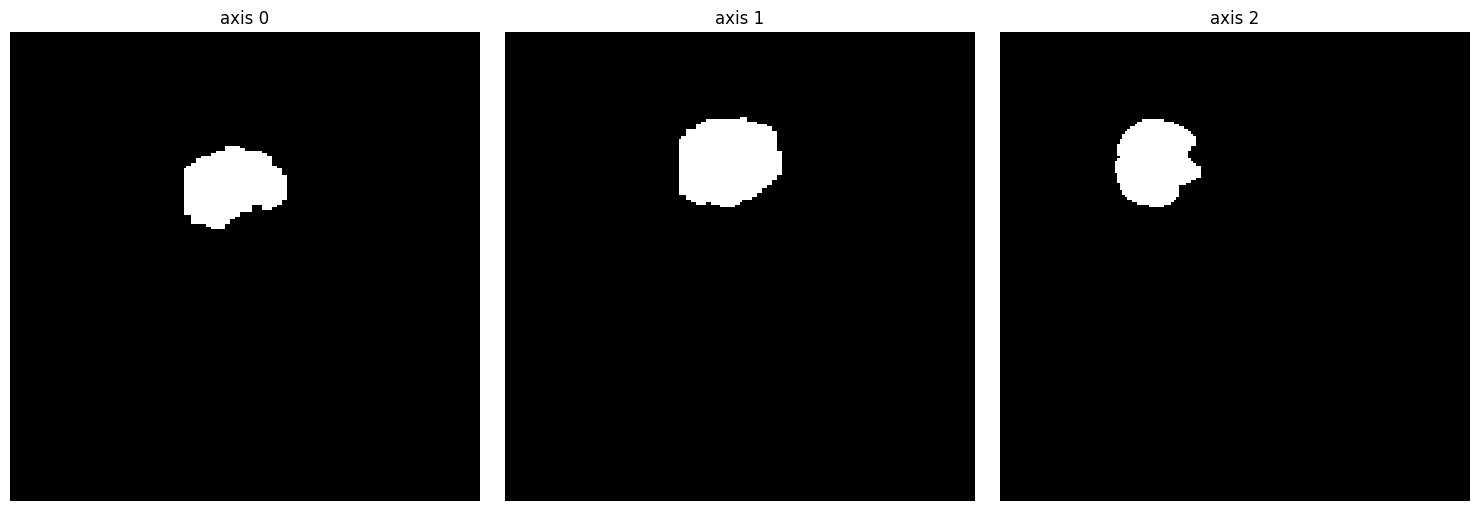

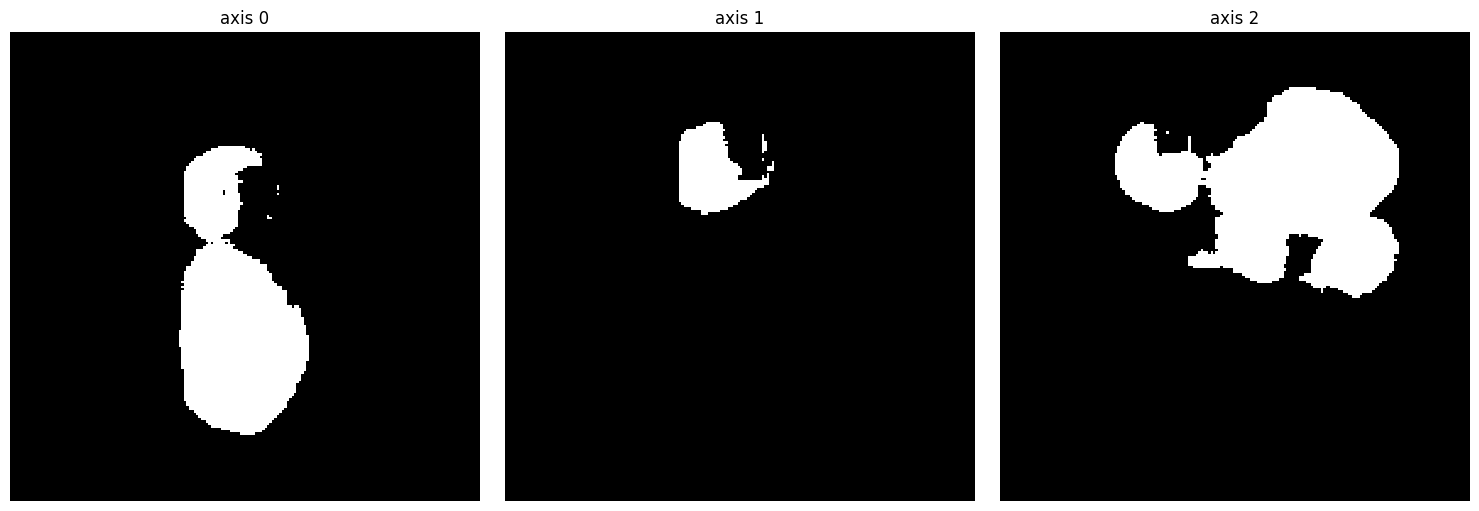

Hard Dice Coefficient: 0.025052560574683296
Soft Dice Coefficient: -0.4906293451786041


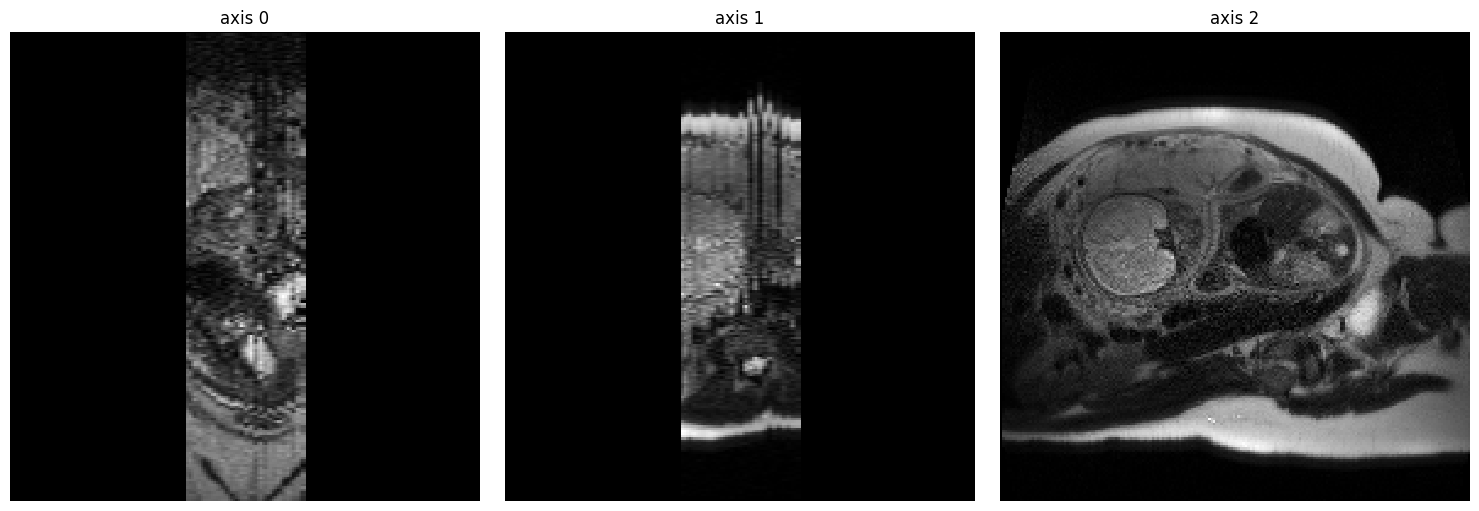

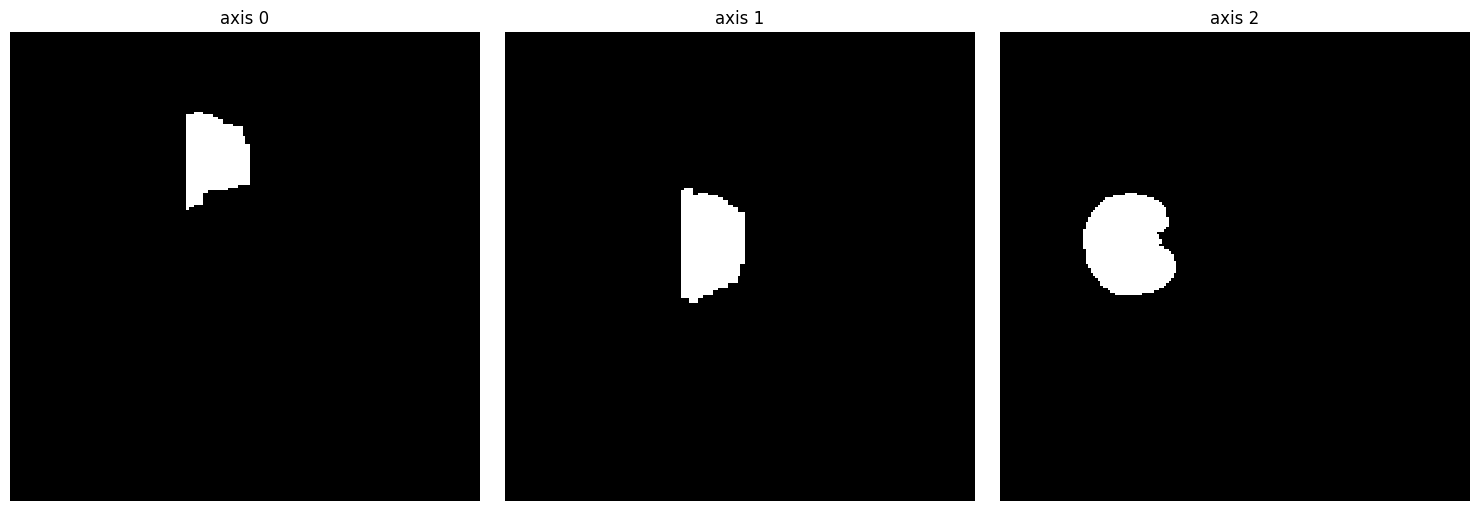

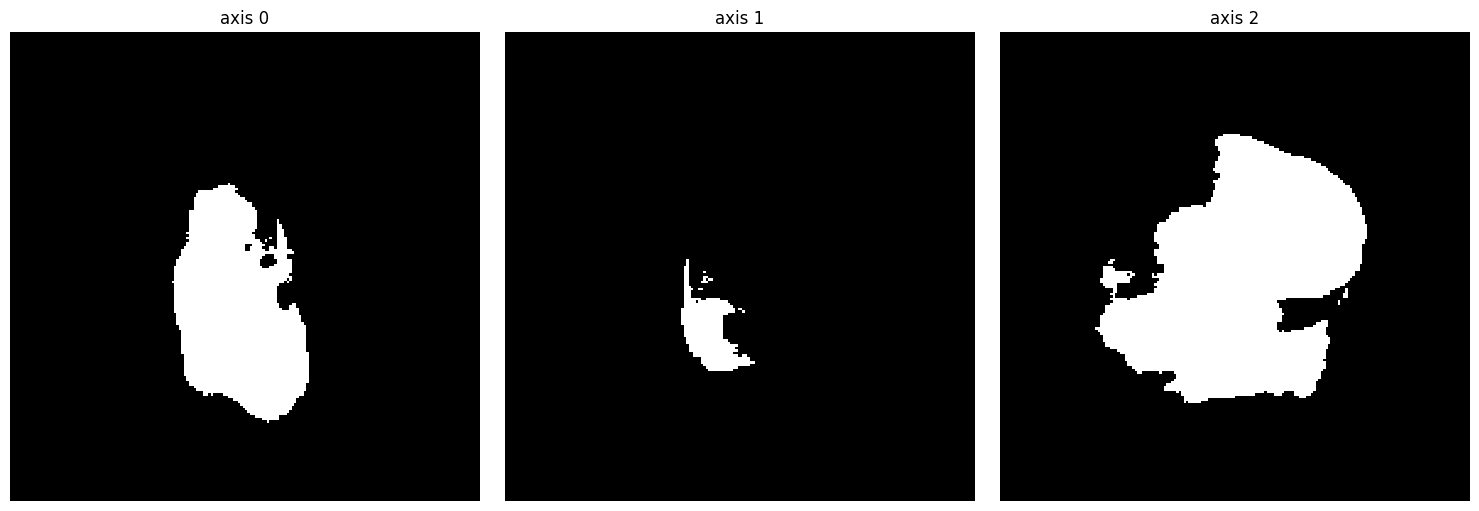

Hard Dice Coefficient: 0.1300591108078477
Soft Dice Coefficient: -0.5056328177452087


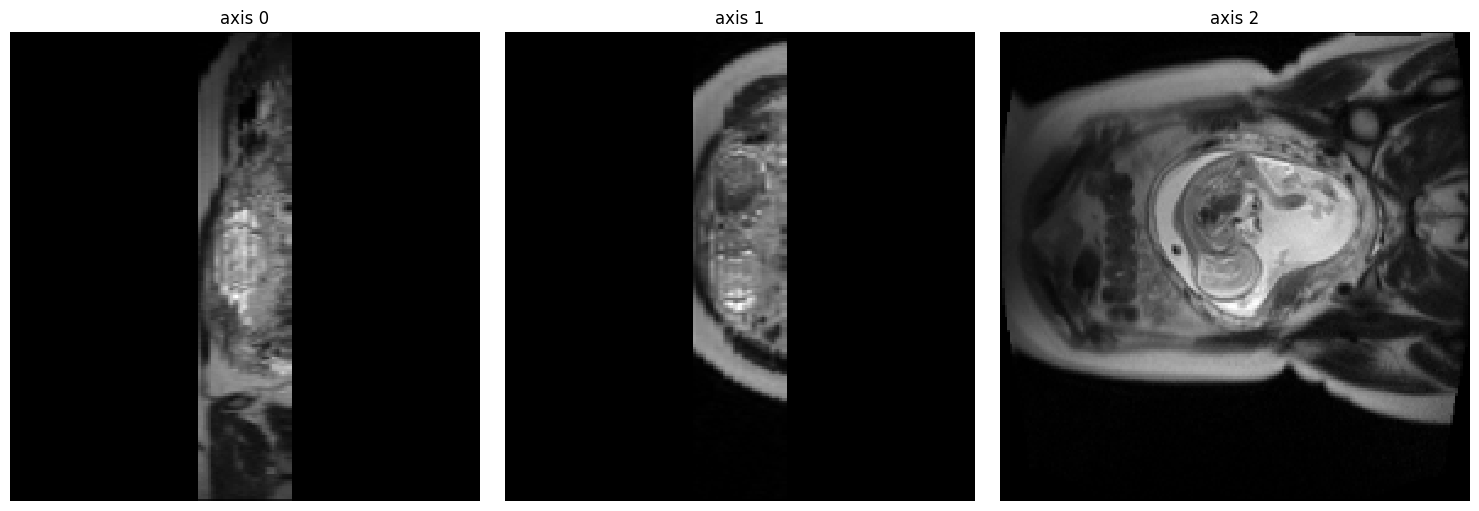

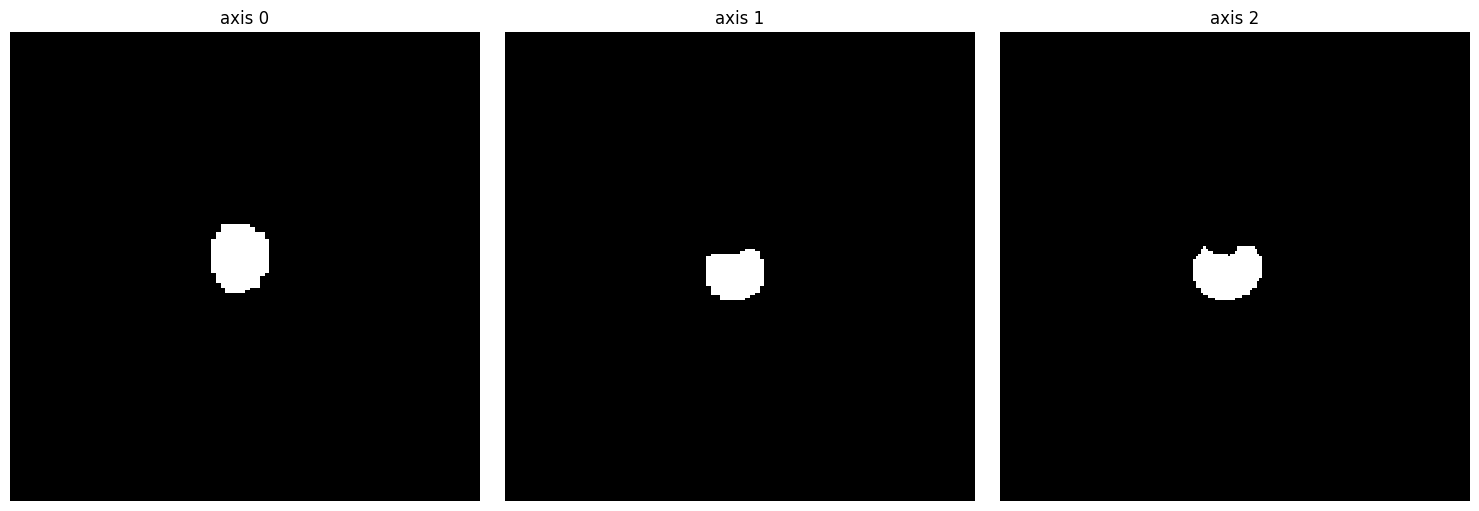

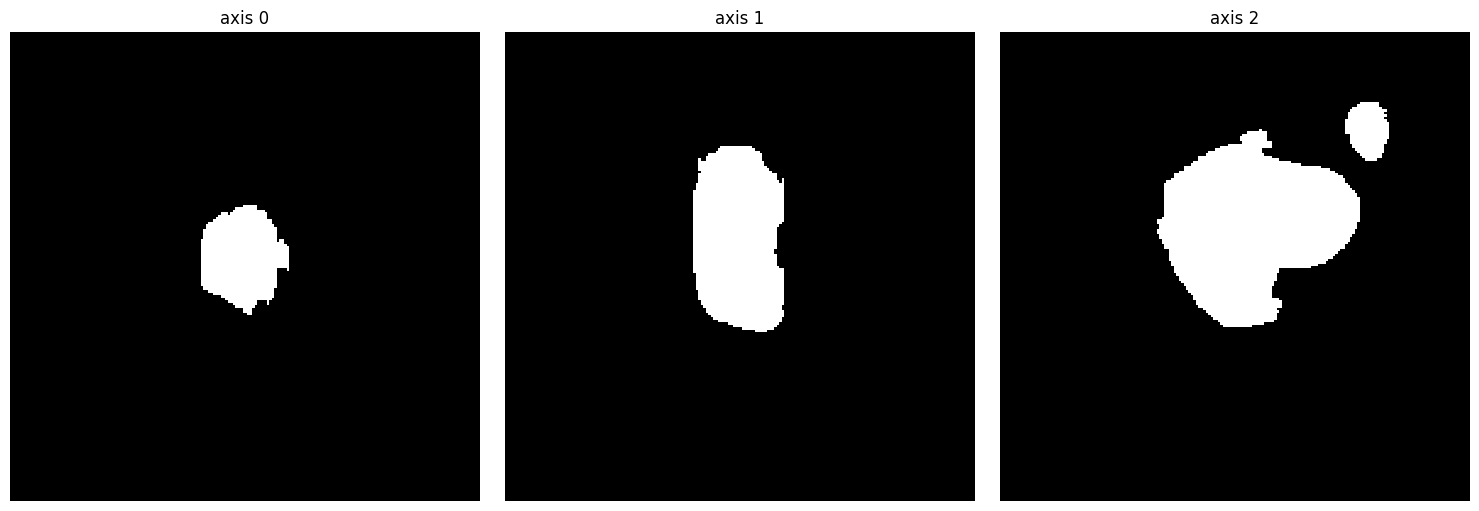

Hard Dice Coefficient: 0.12599556429527067
Soft Dice Coefficient: -0.506363570690155


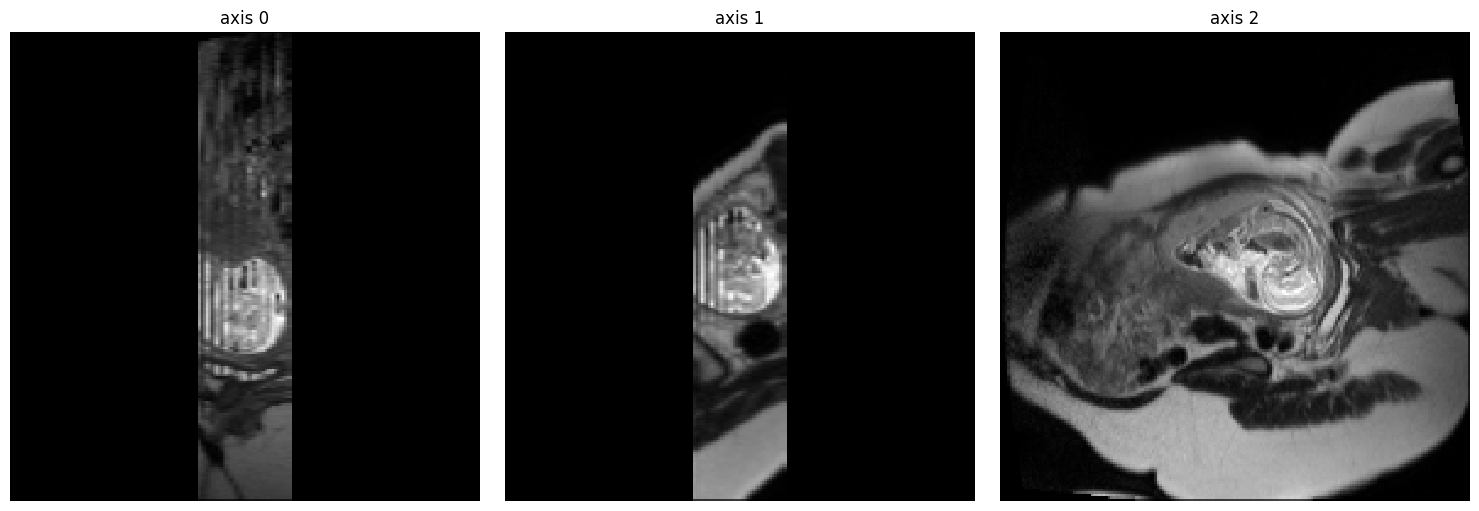

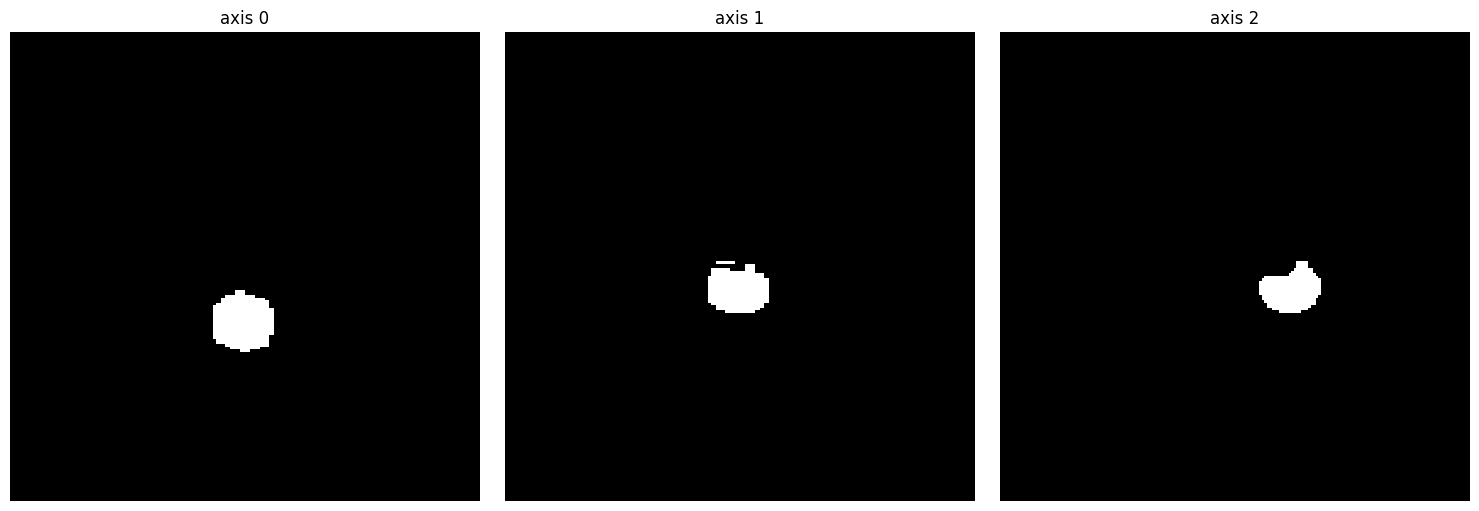

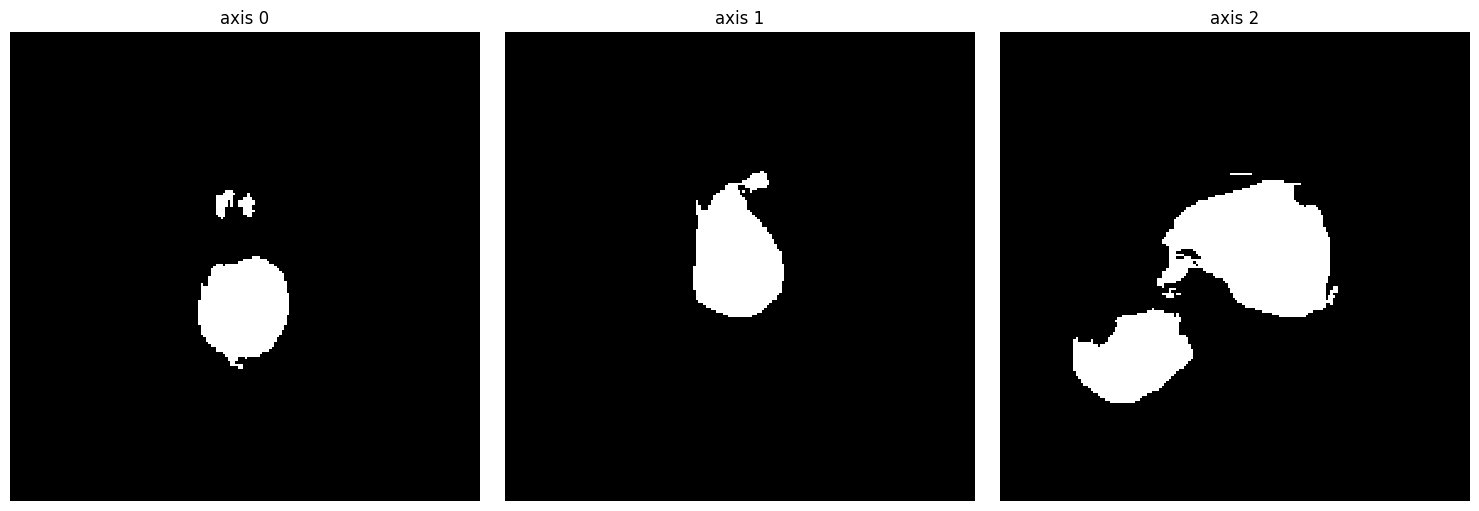

Hard Dice Coefficient: 0.2735267858311711
Soft Dice Coefficient: -0.5233878493309021


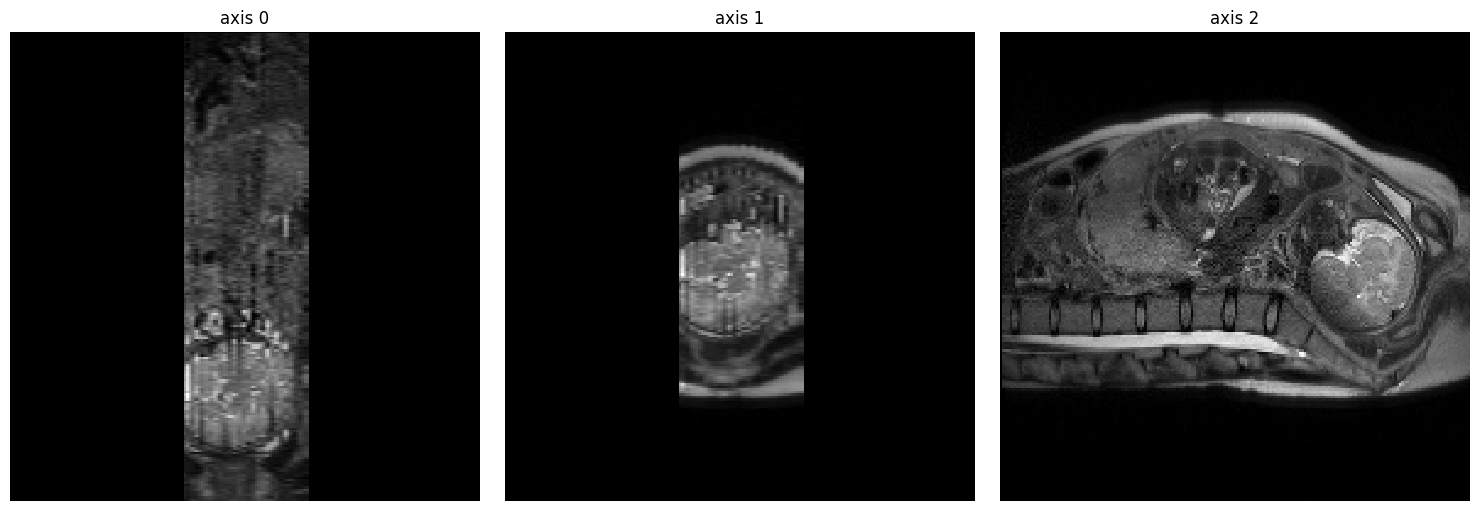

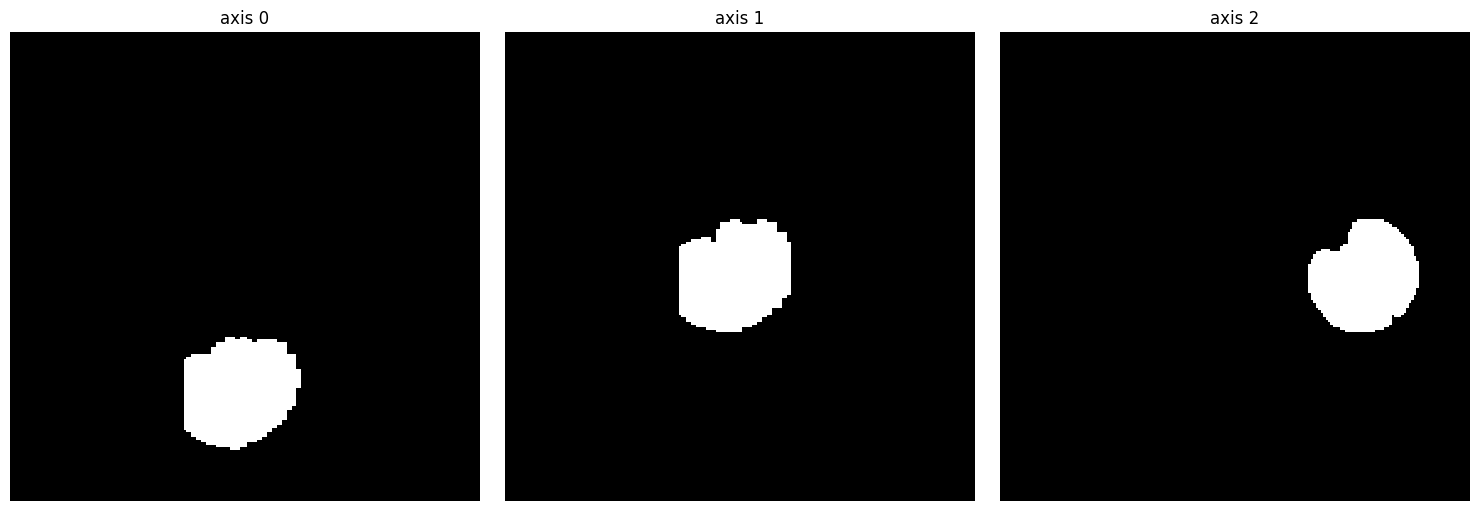

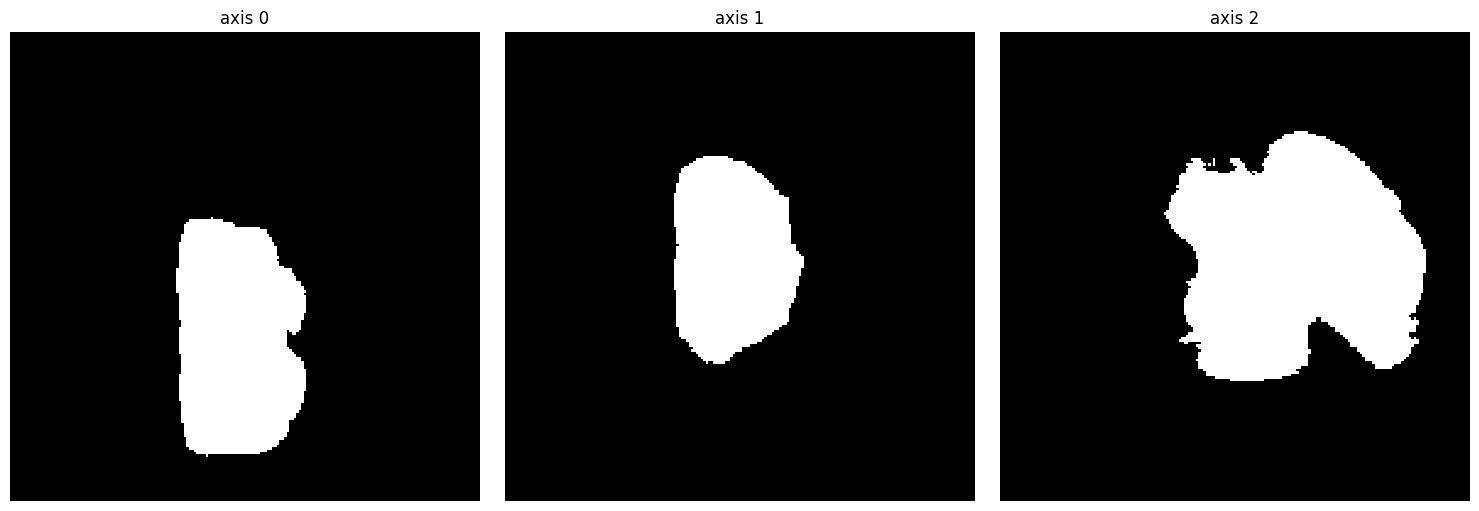

Hard Dice Coefficient: 0.19765242856344906
Soft Dice Coefficient: -0.5198431015014648


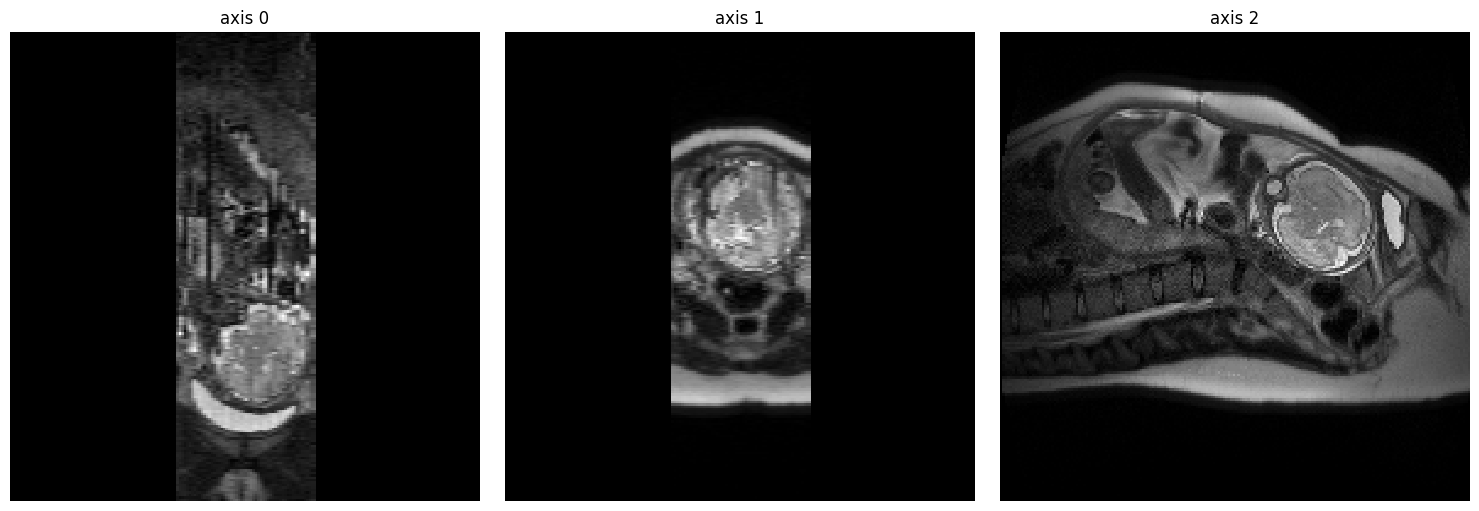

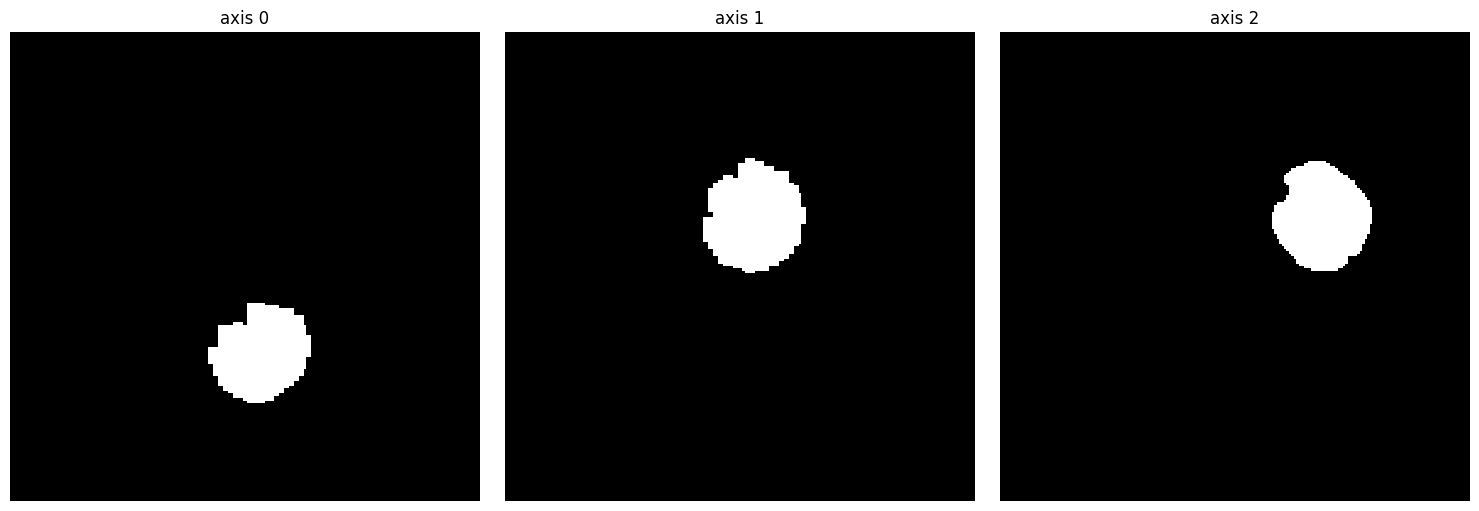

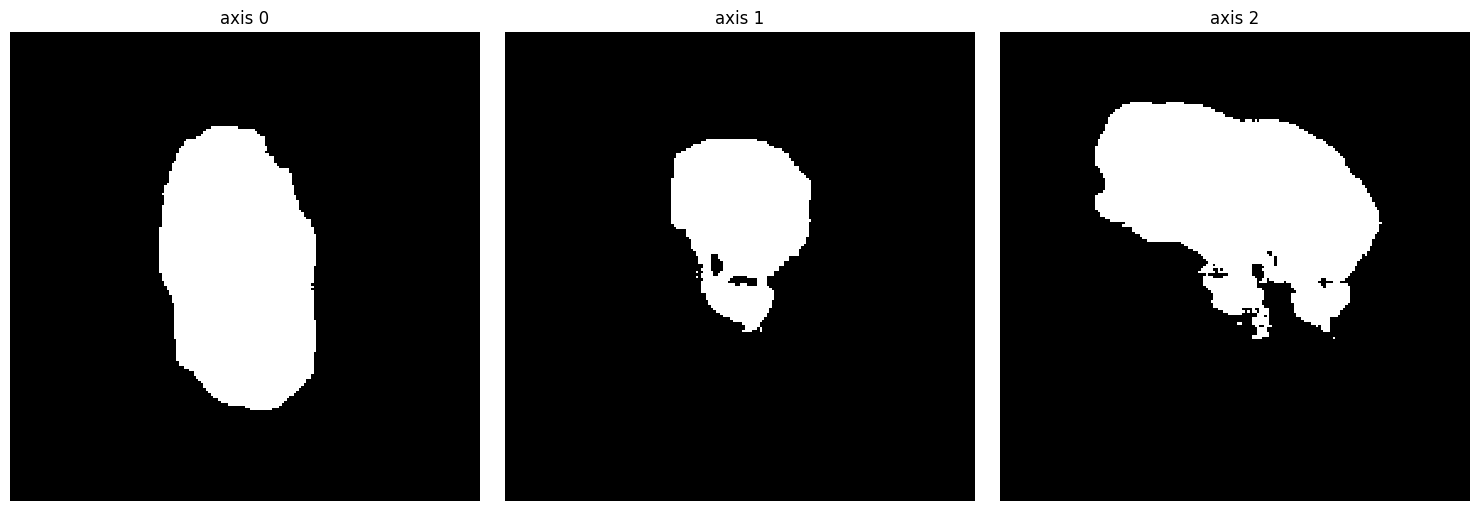

Hard Dice Coefficient: 0.08634592604221673
Soft Dice Coefficient: -0.49969351291656494


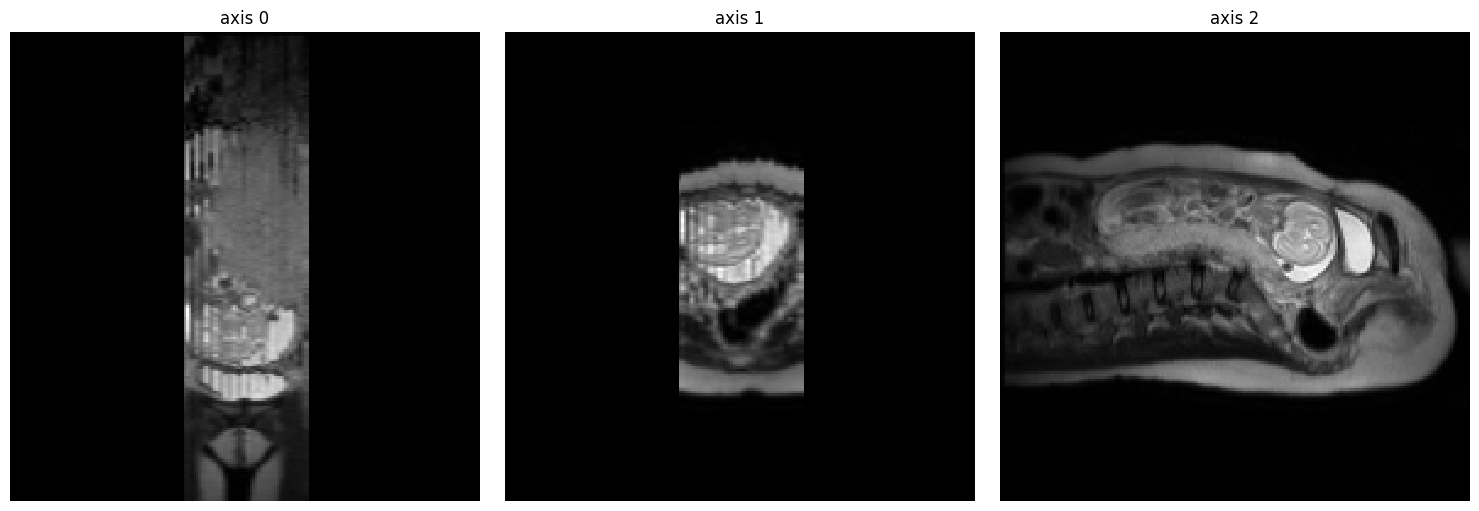

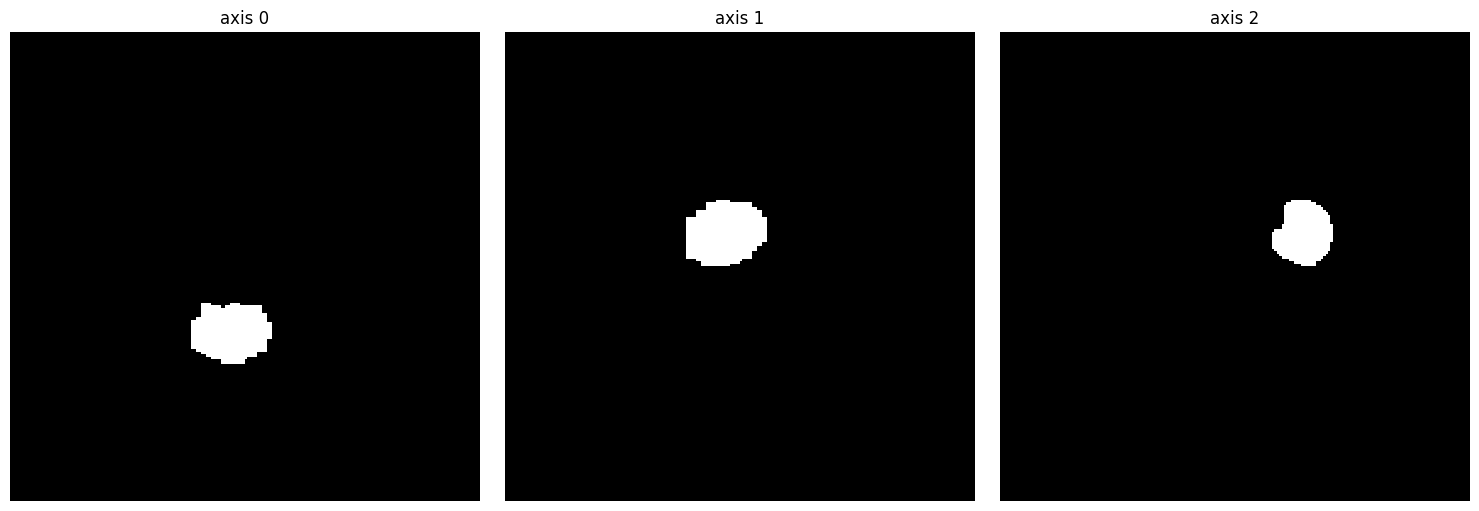

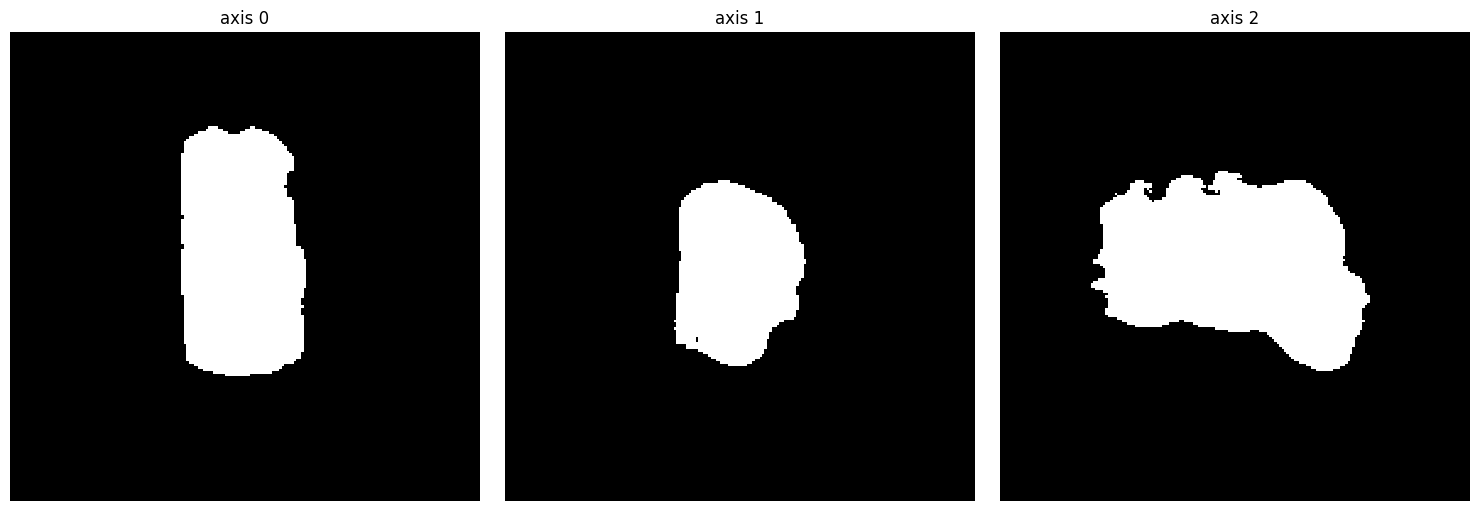

Hard Dice Coefficient: 0.17029508781314076
Soft Dice Coefficient: -0.5107080340385437


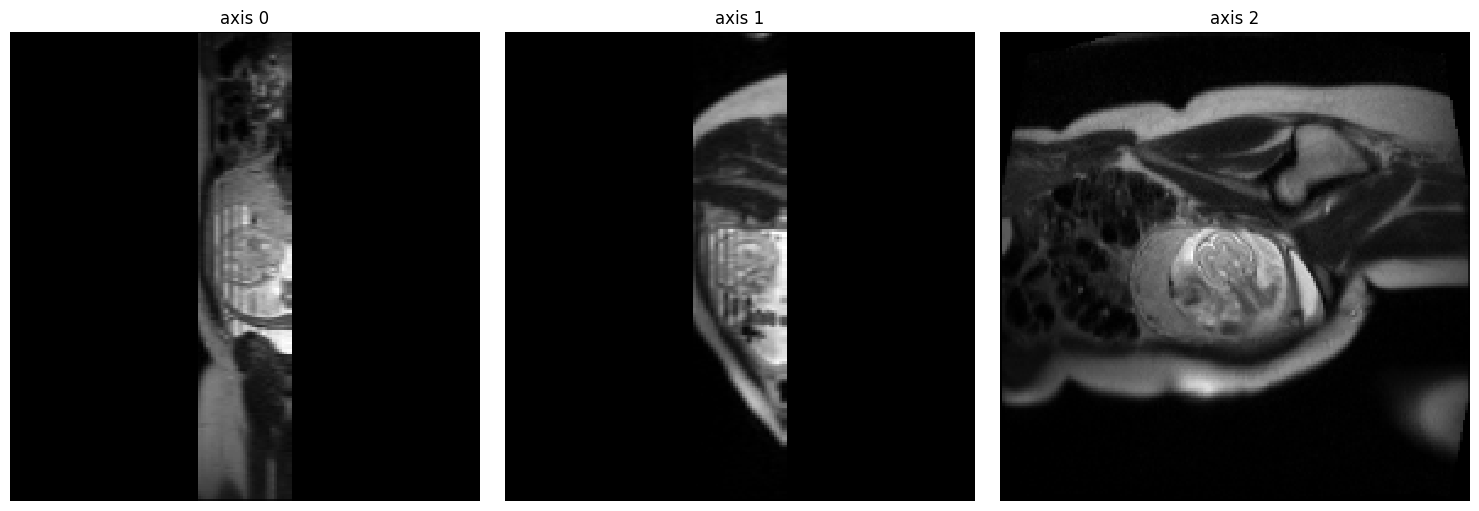

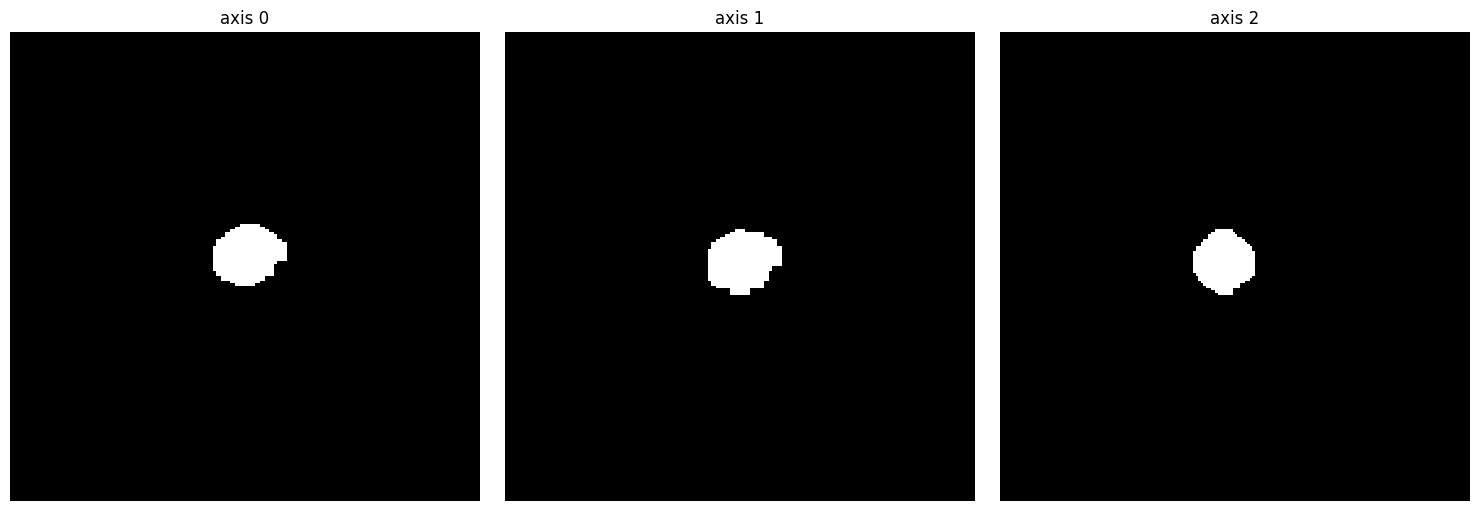

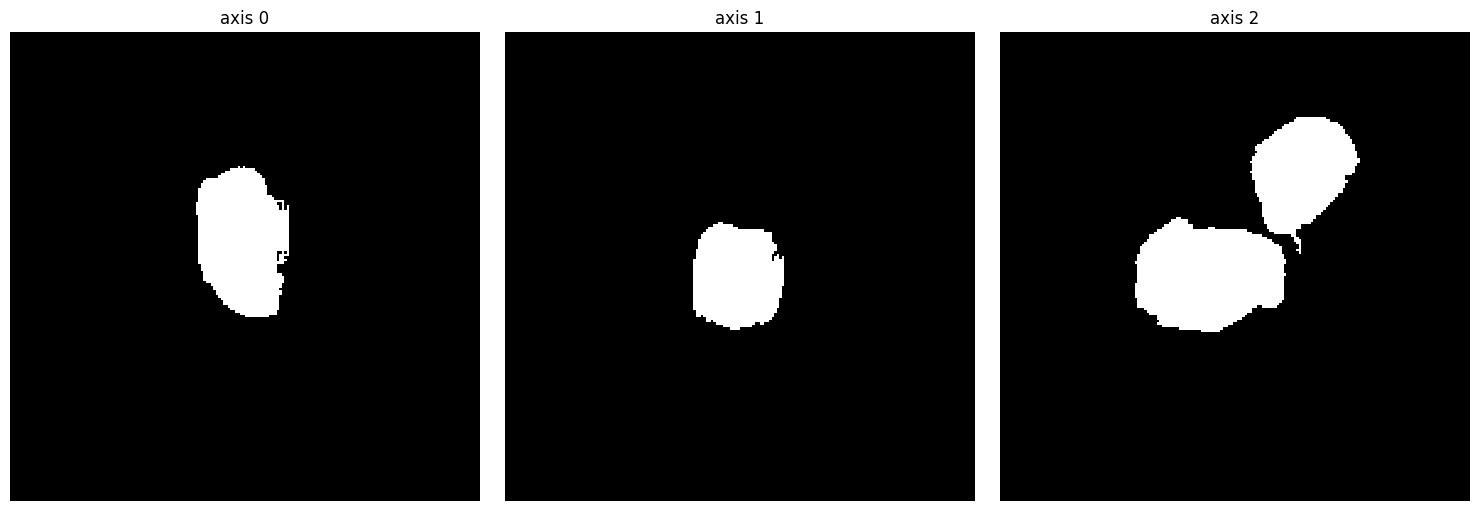

total_hard_dice_score: 0.16329559976808045


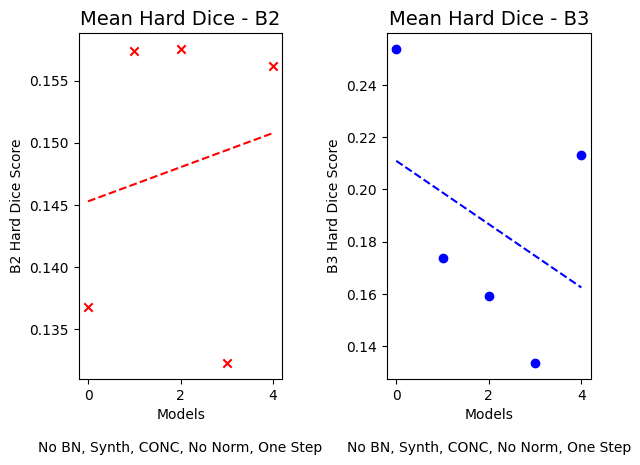

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
from tqdm import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf
import numpy as np
from skimage.measure import label  
import os
import numpy as np
import surfa as sf
from utils import resize
import re
import json
import numpy as np
from sklearn.metrics import f1_score
from keras import backend as K


def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (union) 

def my_hard_dice(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    dice = dice_coefficient(y_true_flat, y_pred_flat)
    return dice
    
    

#     # return not np.any(diff > 0)

    

    
# def soft_dice(a, b):
#     dim = len(a.shape) - 2
#     space = list(range(1, dim + 1))
#     # print("dim",dim,"space",space,"a.dim",a.shape,"b.dim",b.shape)
#     top = 2 * tf.reduce_sum(a * b, axis=space)
#     bot = tf.reduce_sum(a ** 2, axis=space) + tf.reduce_sum(b ** 2, axis=space)
    
#     out = tf.divide(top, bot + 1e-6)
#     return -tf.reduce_mean(out)


    

tf.get_logger().setLevel('ERROR')

warp_blur_min=np.array([2, 4, 8])
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2





random.seed(3000)
def load_detection_model(checkpoint_path,gmm, norm , detection , num_dim=3,nb_labels=2,
                                            dimx=192,
                                            dimy=192,
                                            dimz=192,
                                            batch_size=8,
                                            warp_max=2.5,
                                            warp_min=.5,
                                            warp_blur_min=np.array([2, 4, 8]),
                                            warp_blur_max=warp_blur_min*2,
                                            bias_blur_min=np.array([2, 4, 8]),
                                            bias_blur_max=bias_blur_min*2,
                                            initial_lr=1e-4,
                                            lr = 1e-4,
                                            lr_lin = 1e-4,
                                            nb_levels=5,
                                            conv_size=3,
                                            num_epochs=40000,
                                            num_bg_labels=16,
                                            nb_conv_per_level=2):

    input_img = Input(shape=(dimx, dimy, dimz, 1))
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)) * (1.0) )

    unet_model = vxm.networks.Unet(inshape=(dimx, dimy, dimz, 1), nb_features=(en, de), 
                                   nb_conv_per_level=nb_conv_per_level,
                                   final_activation_function='softmax')

    print("loading detection model!")
    segmentation = unet_model(input_img)
    combined_model = Model(inputs=input_img, outputs=segmentation)


    if os.path.exists(checkpoint_path):
        combined_model.load_weights(checkpoint_path)
        print("Loaded weights from the checkpoint and continued training.")
    else:
        # print(checkpoint_path)
        print("Checkpoint file not found.")
    unet_model = combined_model.layers[-1]

    return unet_model


def load_model3D(checkpoint_path,gmm, norm , ninty_norm, bn ,nb_labels=2,
                                             num_dim=3,
                                            dimx=192,
                                            dimy=192,
                                            dimz=192,
                                            batch_size=8,
                                            warp_max=2.5,
                                            warp_min=.5,
                                            warp_blur_min=np.array([2, 4, 8]),
                                            warp_blur_max=warp_blur_min*2,
                                            bias_blur_min=np.array([2, 4, 8]),
                                            bias_blur_max=bias_blur_min*2,
                                            initial_lr=1e-4,
                                            lr = 1e-4,
                                            lr_lin = 1e-4,
                                            nb_levels=5,
                                            conv_size=3,
                                            num_epochs=40000,
                                            num_bg_labels=16,
                                            nb_conv_per_level=2):

    input_img = Input(shape=(dimx, dimy, dimz, 1))
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )

    unet_model = vxm.networks.Unet(inshape=(dimx, dimy, dimz, 1), nb_features=(en, de), batch_norm=bn,
                           nb_conv_per_level=nb_conv_per_level,
                           final_activation_function='softmax')
    
    print("loading second model!")
    print("bn:",bn,"norm:",norm,"90",ninty_norm)
    if gmm:

        # input_img = Input(shape=(*in_shape,1))
        input_brain = get_brain_tf(input_img)
        _, y_brain = model1(input_brain)

        input_fov = get_fov_tf(input_img)
        
        _, y_fov = model2(input_fov)
        # input_final = y_brain + y_fov * (y_brain == 0)
        input_final = y_brain + tf.cast(y_fov, dtype=tf.int32) * tf.cast(y_brain == 0, dtype=tf.int32)

        generated_img, y = labels_to_image_model(input_final)
        segmentation = unet_model(generated_img)
        combined_model = Model(inputs=input_img, outputs=segmentation)
    elif norm:
        generated_img_norm = min_max_norm(input_img)
        segmentation = unet_model(generated_img_norm)
        combined_model = Model(inputs=input_img, outputs=segmentation)
    else:
        generated_img_norm = percentile_norm_tf(input_img)
        segmentation = unet_model(input_img)
        combined_model = Model(inputs=input_img, outputs=segmentation)

    if os.path.exists(checkpoint_path):
        print(checkpoint_path)
        combined_model.load_weights(checkpoint_path)
        print("Loaded weights from the checkpoint and continued training.")
    else:
        # print(checkpoint_path)
        print("Checkpoint file not found.")
    # print(combined_model.summary())
    # unet_model = combined_model.layers[-1]

    return combined_model


num_row = 3
per_row = 10

    
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.sum(np.logical_and(ground_truth, predicted))
    union = np.sum(np.logical_or(ground_truth, predicted))

    dice_coefficient = (2.0 * intersection) / (union + intersection)
    return dice_coefficient

def print_row_dice_coefficients(i, row_dice_coefficients):
    formatted_dice = [f"   {dice:.4f}" for j, dice in enumerate(row_dice_coefficients)]
    num_spaces = num_row-1
    padding_left = 0
    padding_right = 0

    formatted_output = f"{' ' * padding_left}{'       '.join(formatted_dice)}{' ' * padding_right}"
    print(f' {formatted_output}')
    

def load_models():
    with open("params_192.json", "r") as json_file:
        config = json.load(json_file)

    model1_config = config["brain"]
    model2_config = config["body"]
    model3_config = config["labels_to_image_model"]
    model4_config = config["labels_to_image_model_with_shapes"]
    
    # Convert labels_out keys to integers for all models
    # model1_config["labels_out"] = {int(key): value for key, value in model1_config["labels_out"].items()}
    # model2_config["labels_out"] = {int(key): value for key, value in model2_config["labels_out"].items()}
    model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
    
    model4_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
    # Now you have the modified configuration
    # Brain
    model1 = create_model(model1_config)
    # Body
    model2 = create_model(model2_config)
    # Model
    labels_to_image_model = create_model(model3_config)
    return model1, model2, labels_to_image_model
model1, model2, labels_to_image_model = load_models()
import os, shutil, glob

# models_dir='models_mgh_brain_mgh_body_192'
# models_dir='models_feta_mgh_body_192'
# models_dir = 'models_feta_mgh_brain_mgh_body_192'
# models_dir='models_synth_shapes_feta_192'
# models_dir='models_synth_feta_mgh_brain_mgh_body_192'
# validation_folder_path="EPI_150"
validation_folder_path="validation"
# validation_folder_path="validation_synth"

gmm = False
cm=True
synth=True
conc=True

norm=False
bn=False
ninty_norm = not norm 

two_steps=False

if two_steps:
    step_size=1000
    if cm:
        box_models_dir='models_synth_detection_cm_norm_shapes_feta_192'
        models_dir='models_synth_less_conc_norm_shapes_feta_192'
        # models_dir='models_synth_less_conc_norm_shapes_feta_192'
    else:
        models_dir='models_synth_detection_norm_shapes_feta_192'
elif gmm:
    step_size=2000
    models_dir='models_synth_gmm_mgh_brain_mgh_body_192'
    # models_dir='models_synth_gmm_feta_mgh_body_192'
elif conc:
    step_size=400
    if two_steps:
        box_models_dir='models_synth_detection_cm_norm_shapes_feta_192'
    if synth and norm and bn:
        models_dir='models_synth_less_conc_bn_norm_shapes_feta_192'
    elif synth and ninty_norm and bn:
        models_dir='models_synth_less_conc_bn_90_shapes_feta_192'
    elif synth and not norm and not bn:
        models_dir='models_synth_less_conc_90_shapes_feta_192'
    elif synth and norm and not bn:
        models_dir='models_synth_less_conc_norm_shapes_feta_192'
    else:
        step_size=2000
        models_dir='models_less_conc_shapes_feta_192'
else:
    # models_dir='models_shapes_feta_192'
    if synth:
        step_size=60
        models_dir='models_synth_shapes_feta_192'
    else:
        step_size=500
        models_dir='models_shapes_feta_192'


if synth:
    en = [16, 16, 32 ,32 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 32 ,32 ,16 ,16 ,2]
else:
    en=[16,16, 32,32, 64,64,128,128, 192,192]
    de=[192,192, 128,128,64,64,32,32,16,16,2]


nb_features = '_'.join(map(str, en))
dim_=192

latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
match = re.search(r'(\d+)', latest_weight.split("/")[1])
initial_epoch = int(match.group())

from scipy.ndimage import binary_dilation, binary_erosion
from scipy import ndimage

def eval(subfolders):
    b2_hard_dice_scores=[]
    b3_hard_dice_scores=[]
    last_soft_dice_scores=[]
    latest_images=[]
    latest_masks=[]

    for w in range(0, end_epoch+1, step_size):
        checkpoint_path=models_dir+'/weights_epoch_'+str(w)+'.h5'
        combined_model = load_model3D(checkpoint_path,gmm, norm, ninty_norm, bn, two_steps, num_dim=3, dimx=dim_,
                                                               dimy=dim_,
                                                               dimz=dim_)
    
        b2_10_hard_dice_scores = []
        b3_10_hard_dice_scores = []
        # last_10_soft_dice_scores =[]
        for folder in tqdm(subfolders):
            folder_path = os.path.join(validation_folder_path, folder)
            filename = os.path.join(folder_path,"image.nii.gz")
            mask_filename = os.path.join(folder_path,"manual.nii.gz")
            image = sf.load_volume(filename)
            
            # if validation_folder_path == "EPI_150":
            new_voxsize = [dynamic_resize(image)]*3

                
            # print(new_voxsize)
            orig_voxsize = image.geom.voxsize
            crop_img = image.resize([orig_voxsize[0],orig_voxsize[1],1], method="linear")
            crop_img = crop_img.resize(new_voxsize, method="linear").reshape([dim_, dim_, dim_])
            # crop_data = minmax_norm(crop_img.data)
            # crop_data = percentile_norm(crop_img.data)
            crop_data = crop_img.data
            
            mask = sf.load_volume(mask_filename).resize([orig_voxsize[0],orig_voxsize[1],1
                                                        ], method="linear")
            mask = mask.resize(new_voxsize).reshape([dim_, dim_, dim_, 1])
            mask.data[mask.data != 0] = 1
            # combined_model.summary()
            hard_dice_score = calculate_hard_dice(crop_img, combined_model, mask)
            # print("before mom calc")
            mom_str = folder.split("_")[1]
            # mom = int(folder.split("_")[1])
            if mom_str.isdigit():
                mom = int(mom_str)
                # print("Mom number: ",mom)
                if mom < 100:
                    b2_10_hard_dice_scores.append(hard_dice_score)
                else:
                    b3_10_hard_dice_scores.append(hard_dice_score)
            
            if abs(w-initial_epoch)<step_size:
                # print(mom)
                latest_images.append(crop_img)
                latest_masks.append(mask)
                
        b2_hard_dice_scores.append(np.mean(b2_10_hard_dice_scores))
        b3_hard_dice_scores.append(np.mean(b3_10_hard_dice_scores))
    return latest_images, latest_masks , b2_hard_dice_scores, b3_hard_dice_scores
    
def calculate_hard_dice(image, model, mask):
    # mask = sf.load_volume(mask_filename).reshape((dim_, dim_, dim_))


    prediction_one_hot = process_image(image.data, model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    prediction = np.squeeze(predictions_argmax, axis=0)
    mask.data[mask.data != 0] = 1
    prediction = ndimage.binary_fill_holes(prediction).astype(int)
    return my_hard_dice(prediction.flatten(),mask.data.flatten())

def visualize_1step(combined_model,image,mask, id):
    # crop_img = image.reshape((dim_, dim_, dim_,1))   

    orig_voxsize = image.geom.voxsize
    new_voxsize = [dynamic_resize(image)]*3
    crop_img = image.resize([orig_voxsize[0],orig_voxsize[1],new_voxsize[2]], method="nearest")#.reshape([dim_, dim_, dim_])
    crop_img = image.resize(new_voxsize, method="linear").reshape([dim_, dim_, dim_])
    crop_img = image.reshape([dim_, dim_, dim_])

    crop_data = crop_img.data

    prediction_one_hot = process_image(crop_data, combined_model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    prediction = np.squeeze(predictions_argmax, axis=0)

    prediction = sf.Volume(prediction)#.reshape(mask.data.shape)#.resample_like(mask)

    def soft_dice(a, b):
        dim = len(a.shape) - 2
        space = list(range(1, dim + 1))
    
        top = 2 * tf.reduce_sum(a * b, axis=space)
        bot = tf.reduce_sum(a ** 2, axis=space) + tf.reduce_sum(b ** 2, axis=space)
        # print("top",top,"bot",bot)
        out = tf.divide(top, bot + 1e-6)
        out = tf.clip_by_value(out, -1.0, 1.0) 
        return -tf.reduce_mean(out)
        

    hard_dice_score = my_hard_dice(mask.data, prediction.data)
    soft_dice_score = soft_dice(tf.one_hot(mask.data,depth=2), prediction_one_hot)

    print(f"Hard Dice Coefficient: {hard_dice_score}")
    print(f"Soft Dice Coefficient: {soft_dice_score}")

    nib.save(nib.Nifti1Image(crop_img.astype(np.float32), np.eye(4), header=None), f"output/crop_img_{id}.nii.gz")
    nib.save(nib.Nifti1Image(prediction.data.astype(np.int32), np.eye(4), header=None), f"output/pred_{id}.nii.gz")
    nib.save(nib.Nifti1Image(mask.data.astype(np.int32), np.eye(4), header=None), f"output/mask_{id}.nii.gz")

    mean_slice_numbers = tuple(np.median(indices) for indices in np.where(mask != 0))

    ne.plot.volume3D(crop_img,slice_nos=mean_slice_numbers);
    ne.plot.volume3D(mask,slice_nos=mean_slice_numbers);
    ne.plot.volume3D(prediction,slice_nos=mean_slice_numbers);

    return hard_dice_score 


def visualize_2step(combined_model, box_model,image,mask, id):
    # crop_img = image.reshape((dim_, dim_, dim_,1))   

    orig_voxsize = image.geom.voxsize
    new_voxsize = [dynamic_resize(image)]*3
    crop_img = image.resize([orig_voxsize[0],orig_voxsize[1],1], method="nearest")#.reshape([dim_, dim_, dim_])
    crop_img = image.resize(new_voxsize, method="linear").reshape([dim_, dim_, dim_])
    crop_data = crop_img.data
    # crop_data = percentile_norm(crop_data)

    crop_data_mm = minmax_norm(crop_data)
    box_one_hot = process_image(crop_data_mm, box_model)

    box_one_hot = fit_bounding_rect_box(box_one_hot,margin=1)
    box_argmax = np.argmax(box_one_hot, axis=-1)
    box_pred = np.squeeze(box_argmax, axis=0)
    box_pred = sf.Volume(box_pred)

    crop_data_final = box_pred.data*crop_data.data
    crop_data_final = sf.Volume(crop_data_final)
    prediction_one_hot = process_image(crop_data_final.data, combined_model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    prediction = np.squeeze(predictions_argmax, axis=0)


    prediction = sf.Volume(prediction)#.reshape(mask.data.shape)#.resample_like(mask)
    # mask.data[mask.data != 0] = 1

    hard_dice_score = my_hard_dice(mask.data, prediction.data)
    print(f"Hard Dice Coefficient: {hard_dice_score}")
    encompass_dice_score = all_non_zero_inside(mask.data, box_pred.data)
    print(f"Encompass Score: {encompass_dice_score}")

    nib.save(nib.Nifti1Image(crop_img.astype(np.float32), np.eye(4), header=None), f"output/crop_img_{id}.nii.gz")
    nib.save(nib.Nifti1Image(prediction.data.astype(np.int32), np.eye(4), header=None), f"output/pred_{id}.nii.gz")
    nib.save(nib.Nifti1Image(mask.data.astype(np.int32), np.eye(4), header=None), f"output/mask_{id}.nii.gz")

    mean_slice_numbers = tuple(np.median(indices) for indices in np.where(mask != 0))

    ne.plot.volume3D(crop_img,slice_nos=mean_slice_numbers);
    ne.plot.volume3D(mask,slice_nos=mean_slice_numbers);
    ne.plot.volume3D(crop_data_final,slice_nos=mean_slice_numbers);
    ne.plot.volume3D(prediction,slice_nos=mean_slice_numbers);

    return hard_dice_score , encompass_dice_score


last_models_hard_dice_scores = []
n = 500
# for i in range(latest_epoch, latest_epoch - n, -10):
def load_model(models_dir,detection=False):
    latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    match = re.search(r'(\d+)', latest_weight.split("/")[1])
    initial_epoch = int(match.group())

    checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'
    print(checkpoint_path,"detection",detection)
    if detection:
        combined_model = load_detection_model(checkpoint_path,gmm,norm, detection, num_dim=3, dimx=dim_,
                                                               dimy=dim_,
                                                               dimz=dim_)
    else:
        combined_model = load_model3D(checkpoint_path,gmm,norm, ninty_norm, bn, num_dim=3, dimx=dim_,
                                                               dimy=dim_,
                                                               dimz=dim_)
    return combined_model

combined_model = load_model(models_dir,detection=False)




subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]


new_voxsize = [0.65,0.65,0.65]

b2_hard_dice_scores=[]
b3_hard_dice_scores=[]

end_epoch = 0 + step_size * ((initial_epoch) // step_size)

latest_images, latest_masks , b2_hard_dice_scores, b3_hard_dice_scores = eval(subfolders)  
total_encompass_dice_score = 0
total_hard_dice_score = 0
if two_steps:
    box_model = load_model(box_models_dir,detection=True)
    for i in range(len(latest_images)):
        hard_dice_score , encompass_dice_score = visualize_2step(combined_model, box_model,latest_images[i],latest_masks[i],i)
        total_encompass_dice_score +=encompass_dice_score
        total_hard_dice_score +=hard_dice_score
    print("total_hard_dice_score:",total_hard_dice_score/len(latest_images))
    print("total_encompass_dice_score:",total_encompass_dice_score/len(latest_images))
else:
    for i in range(len(latest_images)):
        hard_dice_score  = visualize_1step(combined_model,latest_images[i],latest_masks[i],i)
        total_hard_dice_score +=hard_dice_score
    print("total_hard_dice_score:",total_hard_dice_score/len(latest_images))


b2 = b2_hard_dice_scores
b3 = b3_hard_dice_scores

bn_status = 'BN' if bn else 'No BN'
synth_status = 'Synth' if synth else 'Big Model'
conc_status = 'CONC' if conc else ''
norm_status = 'Norm' if norm else 'No Norm'
steps_status = 'Two Steps' if two_steps else 'One Step'

# Plot for B2
plt.subplot(1, 2, 1)
plt.scatter(range(len(b2)), b2, c='red', marker='x')
plt.plot(range(len(b2)), np.poly1d(np.polyfit(range(len(b2)), b2, 1))(range(len(b2))), 'r--')
plt.xlabel('Models'), plt.ylabel('B2 Hard Dice Score')

# Main title
plt.title(f'Mean Hard Dice - B2', fontsize=14)

# Subtitle
plt.text(0.5, -0.2, f'{bn_status}, {synth_status}, {conc_status}, {norm_status}, {steps_status}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Plot for B3
plt.subplot(1, 2, 2)
plt.scatter(range(len(b3)), b3, c='blue', marker='o')
plt.plot(range(len(b3)), np.poly1d(np.polyfit(range(len(b3)), b3, 1))(range(len(b3))), 'b--')
plt.xlabel('Models'), plt.ylabel('B3 Hard Dice Score')

# Main title
plt.title(f'Mean Hard Dice - B3', fontsize=14)

# Subtitle
plt.text(0.5, -0.2, f'{bn_status}, {synth_status}, {conc_status}, {norm_status}, {steps_status}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [8]:
b3

[0.1376729273484904]